In [63]:
"""
Planar quadrotor animation using `matplotlib`.
Author: Spencer M. Richards
        Autonomous Systems Lab (ASL), Stanford
        (GitHub: spenrich)
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
import matplotlib.animation as animation


def animate_planar_quad_with_inverted_pendulum(t, x, y, θ, ϕ, title_string=None, display_in_notebook=False):
    """Animate the planar quadrotor system from given position data.
    All arguments are assumed to be 1-D NumPy arrays, where `x`, `y`, `θ`, and `ϕ`
    are the degrees of freedom of the planar quadrotor over time `t`.
    Example usage:
        import matplotlib.pyplot as plt
        from animations import animate_planar_quad
        fig, ani = animate_planar_quad_with_inverted_pendulum(t, x, y, θ, ϕ)
        ani.save('planar_quad.mp4', writer='ffmpeg')
        plt.show()
    """
    # Geometry
    rod_width = 2.
    rod_height = 0.15
    axle_height = 0.2
    axle_width = 0.05
    prop_width = 0.5 * rod_width
    prop_height = 1.5 * rod_height
    hub_width = 0.3 * rod_width
    hub_height = 2.5 * rod_height
    
    
    # Add pendulum 
    pole_length = rod_width
    mass_radius = 0.25
    
    

    # Figure and axis
    fig, ax = plt.subplots(dpi=100)
    x_min, x_max = np.min(x) - pole_length, np.max(x) + pole_length # increase x limit for pendulum
    x_pad = (rod_width + prop_width) / 2 + 0.1 * (x_max - x_min)
    y_min, y_max = np.min(y) - pole_length, np.max(y) + pole_length # increase y limit for pendulum
    y_pad = (rod_width + prop_width) / 2 + 0.1 * (y_max - y_min)
    ax.set_xlim([x_min - x_pad, x_max + x_pad])
    ax.set_ylim([y_min - y_pad, y_max + y_pad])
    ax.set_aspect(1.)
    if title_string is not None:
        plt.title(title_string)

    # Artists
    rod = mpatches.Rectangle((-rod_width / 2, -rod_height / 2),
                             rod_width,
                             rod_height,
                             facecolor='tab:blue',
                             edgecolor='k')
    hub = mpatches.FancyBboxPatch((-hub_width / 2, -hub_height / 2),
                                  hub_width,
                                  hub_height,
                                  facecolor='tab:blue',
                                  edgecolor='k',
                                  boxstyle='Round,pad=0.,rounding_size=0.05')
    axle_left = mpatches.Rectangle((-rod_width / 2, rod_height / 2),
                                   axle_width,
                                   axle_height,
                                   facecolor='tab:blue',
                                   edgecolor='k')
    axle_right = mpatches.Rectangle((rod_width / 2 - axle_width, rod_height / 2),
                                    axle_width,
                                    axle_height,
                                    facecolor='tab:blue',
                                    edgecolor='k')
    prop_left = mpatches.Ellipse(((axle_width - rod_width) / 2, rod_height / 2 + axle_height),
                                 prop_width,
                                 prop_height,
                                 facecolor='tab:gray',
                                 edgecolor='k',
                                 alpha=0.7)
    prop_right = mpatches.Ellipse(((rod_width - axle_width) / 2, rod_height / 2 + axle_height),
                                  prop_width,
                                  prop_height,
                                  facecolor='tab:gray',
                                  edgecolor='k',
                                  alpha=0.7)
    
    # Add pendulum parts pole & mass
    mass = mpatches.Circle((0., 0.), mass_radius, color='k')
    pole = ax.plot([], [], '-', linewidth=2, color='k')[0]
    
    patches = (rod, hub, axle_left, axle_right, prop_left, prop_right, mass) # Add pendulum mass
    for patch in patches:
        ax.add_patch(patch)
    trace = ax.plot([], [], '--', linewidth=2, color='tab:orange')[0]
    timestamp = ax.text(0.1, 0.9, '', transform=ax.transAxes)

    def animate(k, t, x, y, θ, ϕ):
        # Add Pendulum
        pole_start = np.array([x[k], y[k]])
        pole_end = pole_start + pole_length*np.array([np.sin(ϕ[k]),
                                                      -np.cos(ϕ[k])])
        
        # Pendulum
        pole.set_data([pole_start[0], pole_end[0]],
                      [pole_start[1], pole_end[1]])
        mass.set_center(pole_end)
        mass_x = x[:k+1] + pole_length*np.sin(ϕ[:k+1])
        mass_y = y[:k+1] - pole_length*np.cos(ϕ[:k+1])
        #trace.set_data(mass_x, mass_y) # if we want to trace pendulum mass
        
        
        transform = mtransforms.Affine2D().rotate_around(0., 0., θ[k])
        transform += mtransforms.Affine2D().translate(x[k], y[k])
        transform += ax.transData
    
        patches = (rod, hub, axle_left, axle_right, prop_left, prop_right) # we don't want to transform pendulum
        
        for patch in patches:
            patch.set_transform(transform)
        trace.set_data(x[:k + 1], y[:k + 1]) # if we want to trace the drone position
        timestamp.set_text('t = {:.1f} s'.format(t[k]))
        
        artists = patches + (mass, pole, trace, timestamp) # Add mass and pole (inverted pendulum)
        return artists

    dt = t[1] - t[0]
    step = max(int(np.floor((1 / 30) / dt)), 1)  # max out at 30Hz for faster rendering
    ani = animation.FuncAnimation(fig,
                                  animate,
                                  t[::step].size,
                                  fargs=(t[::step], x[::step], y[::step], θ[::step], ϕ[::step]), 
                                  interval=step * dt * 1000,
                                  blit=True)
    if display_in_notebook:
        try:
            get_ipython()
            from IPython.display import HTML
            ani = HTML(ani.to_html5_video())
        except (NameError, ImportError):
            raise RuntimeError("`display_in_notebook = True` requires this code to be run in jupyter/colab.")
    plt.close(fig)
    return ani

# Test Animation

In [2]:
animate_planar_quad_with_inverted_pendulum(np.array([0,1]), np.array([0,2]), np.array([0,5]), np.array([0,0]), np.array([0,0]), display_in_notebook=True)
#ani = ani.save('planar_quad.mp4', writer='ffmpeg')

In [71]:
import sympy as sp
from scipy.optimize import minimize, Bounds
import pickle
import os

# Dynamic Equation

In [17]:
def dynamics_eq():
    g = sp.symbols('g')

    # Pendulum
    L = sp.symbols('L')
    mp = sp.symbols(r'm_p')
    Ip = sp.symbols(r'I_p')

    # Drone
    mQ = sp.symbols(r'm_Q')
    IQ = sp.symbols(r'I_Q')
    l = sp.symbols('l')

    T1 = sp.symbols(r'T_1')
    T2 = sp.symbols(r'T_2')

    Rx = sp.symbols(r'R_x')
    Ry = sp.symbols(r'R_y')

    # Drone angle
    θ = sp.symbols(r'\theta')
    dθ = sp.symbols(r'\dot{\theta}')
    ddθ = sp.symbols(r'\ddot{\theta}')

    # Pendulum angle
    ϕ = sp.symbols(r'\phi')
    dϕ = sp.symbols(r'\dot{\phi}')
    ddϕ = sp.symbols(r'\ddot{\phi}')

    # drone x
    x = sp.symbols(r'x')
    dx = sp.symbols(r'\dot{x}')
    ddx = sp.symbols(r'\ddot{x}')

    # drone y
    y = sp.symbols(r'y')
    dy = sp.symbols(r'\dot{y}')
    ddy = sp.symbols(r'\ddot{y}')
    
    ddx_p = ddx - L*ddϕ*sp.sin(ϕ-sp.pi/2)-dϕ**2*L*sp.cos(ϕ-sp.pi/2)
    ddy_p = ddy + L*ddϕ*sp.cos(ϕ-sp.pi/2)-dϕ**2*L*sp.sin(ϕ-sp.pi/2)
    
    eq1 = Rx*sp.cos(θ)-Ry*sp.sin(θ)-mp*ddx_p
    eq2 = Rx*sp.sin(θ)+Ry*sp.cos(θ)-mp*g-mp*ddy_p
    eq3 = Rx*sp.sin(ϕ-sp.pi/2-θ)*L/2 - Ry*sp.cos(ϕ-sp.pi/2-θ)*L/2-mp*g*(L/2)*sp.cos(ϕ-sp.pi/2)-Ip*ddϕ
    eq4 = -Rx*sp.cos(θ)+Ry*sp.sin(θ)-T1*sp.sin(θ)-T2*sp.sin(θ)-mQ*ddx
    eq5 = -Rx*sp.sin(θ)-Ry*sp.cos(θ)+T1*sp.cos(θ)+T2*sp.cos(θ)-mQ*g-mQ*ddy
    eq6 = T2*l-T1*l-IQ*ddθ
    
    sols = sp.solve([eq1,eq2,eq3,eq4,eq5,eq6], (Rx, Ry, ddx, ddy, ddθ, ddϕ), simplify=True)
    
    ddx_func = sp.lambdify((Ip, mp, L, ϕ, dϕ, IQ, mQ, l, θ, dθ, T1, T2, g), sols[ddx]) 
    ddy_func = sp.lambdify((Ip, mp, L, ϕ, dϕ, IQ, mQ, l, θ, dθ, T1, T2, g), sols[ddy]) 
    ddθ_func = sp.lambdify((Ip, mp, L, ϕ, dϕ, IQ, mQ, l, θ, dθ, T1, T2, g), sols[ddθ]) 
    ddϕ_func = sp.lambdify((Ip, mp, L, ϕ, dϕ, IQ, mQ, l, θ, dθ, T1, T2, g), sols[ddϕ]) 
    
    return (ddx_func, ddy_func, ddθ_func, ddϕ_func)

In [18]:
(ddx_func, ddy_func, ddθ_func, ddϕ_func) = dynamics_eq()

# Planar Quadrotor - Direct Method

In [19]:
class PlanarQuadrotorDynamicsWithInvertedPendulum:

    def __init__(self):
        # Dynamics constants
        # yapf: disable
        self.g = 9.807         # gravity (m / s**2)
        self.mQ = 2.5           # mass (kg)
        self.l = 1.0           # half-length (m)
        self.IQ = 1.0         # moment of inertia about the out-of-plane axis (kg * m**2)
        # yapf: enable
        
        # Pendulum
        self.mp = self.mQ*0.8
        self.L = self.l*2
        self.Ip = self.mp*(self.L/2)**2
        

    def __call__(self, state, control):
        """Continuous-time dynamics of a planar quadrotor expressed as an ODE."""
        x, y, θ, ϕ, dx, dy, dθ, dϕ = state
        T1, T2 = control
        return np.array([
            dx,
            dy,
            dθ,
            dϕ,
            ddx_func(self.Ip, self.mp, self.L, ϕ, dϕ, self.IQ, self.mQ, self.l, θ, dθ, T1, T2, self.g),
            ddy_func(self.Ip, self.mp, self.L, ϕ, dϕ, self.IQ, self.mQ, self.l, θ, dθ, T1, T2, self.g),
            ddθ_func(self.Ip, self.mp, self.L, ϕ, dϕ, self.IQ, self.mQ, self.l, θ, dθ, T1, T2, self.g),
            ddϕ_func(self.Ip, self.mp, self.L, ϕ, dϕ, self.IQ, self.mQ, self.l, θ, dθ, T1, T2, self.g),
        ])

In [26]:
def pack_decision_variables(s, u, t_f = None, fixed_final_time = True):
    """Packs decision variables (final time, states, controls) into a 1D vector.
    
    Args:
        t_f: Final time, a scalar.
        s: States, an array of shape (N + 1, s_dim).
        u: Controls, an array of shape (N, u_dim).
    Returns:
        An array `z` of shape (1 + (N + 1) * s_dim + N * u_dim,).
    """
    if fixed_final_time:
        return np.concatenate([s.ravel(), u.ravel()])
    else:
        return np.concatenate([[t_f], s.ravel(), u.ravel()])

def unpack_decision_variables(z, fixed_final_time = True):
    """Unpacks a 1D vector into decision variables (final time, states, controls).
    
    Args:
        z: An array of shape (1 + (N + 1) * s_dim + N * u_dim,).
    Returns:
        t_f: Final time, a scalar.
        s: States, an array of shape (N + 1, s_dim).
        u: Controls, an array of shape (N, u_dim).
    """
    if fixed_final_time:
        s = z[0:(N + 1) * s_dim].reshape(N + 1, s_dim)
        u = z[-N * u_dim:].reshape(N, u_dim)
        return s, u
    else:
        t_f = z[0]
        s = z[1:1 + (N + 1) * s_dim].reshape(N + 1, s_dim)
        u = z[-N * u_dim:].reshape(N, u_dim)
        return t_f, s, u

In [40]:
d2r = np.pi/180
r2d = 180/np.pi

In [51]:
N = 50  # Number of time discretization nodes (0, 1, ... N).
s_dim = 8  # State dimension;
u_dim = 2  # Control dimension; 
t_f = 10  # fixed final time
dt = t_f / N

s_0 = np.array([0, 0, 0, np.pi-20*d2r, 0, 0, 0, 0])  # Initial state.
s_f = np.array([5, 5, 0, np.pi, 0, 0, 0, 0])  # Final state.

In [52]:
def optimize_trajectory():
    dynamics = PlanarQuadrotorDynamicsWithInvertedPendulum()
    
    def cost(z):
        s, u = unpack_decision_variables(z)
        return (dt) * np.sum(np.square(u))
    
    def constraints(z):
        states, controls = unpack_decision_variables(z)
        constraint_list = [states[0]-s_0, states[-1]-s_f]
        for i in range(N):
            constraint_list.append(states[i+1]-(states[i]+(dt)*dynamics(states[i], controls[i])))
        return np.concatenate(constraint_list)
    
    z_guess = pack_decision_variables(np.linspace(s_0, s_f, N+1), np.ones((N, u_dim)))
    
    z_iterates = [z_guess]
    #bnds = [(0, t_f)] + [(-np.inf,np.inf),(-np.inf,np.inf),(0,2*np.pi),(0,2*np.pi),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf)]*(N+1) + [(0,np.inf),(0,np.inf)]*(N)
    bnds = [(-np.inf,np.inf),(-np.inf,np.inf),(0,2*np.pi),(0,2*np.pi),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf)]*(N+1) + [(0,np.inf),(0,np.inf)]*(N)
    
    result = minimize(cost,
                      z_guess,
                      method=None,
                      bounds=bnds,
                      constraints={'type':'eq','fun':constraints},
                      options={'maxiter':1000},
                      callback=lambda z:z_iterates.append(z))
    
    z_iterates = np.stack(z_iterates)
    z = result.x
    return (unpack_decision_variables(z))

In [53]:
s, u = optimize_trajectory()

In [54]:
t = np.linspace(0, t_f, N + 1)

In [64]:
animate_planar_quad_with_inverted_pendulum(t, s[:,0], s[:,1], s[:,2], s[:,3], display_in_notebook=True)

In [65]:
ani = animate_planar_quad_with_inverted_pendulum(t, s[:,0], s[:,1], s[:,2], s[:,3], display_in_notebook=False)
ani = ani.save('planar_quad_with_inverted_pendulum.mp4', writer='ffmpeg')

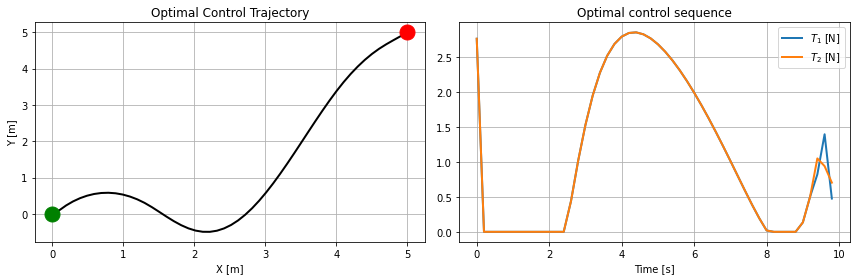

In [77]:
T1 = u[:, 0]
T2 = u[:, 1]

x = s[:, 0]
y = s[:, 1]
θ = s[:, 2]
ϕ = s[:, 3]

data = {'t_f': t, 's': s, 'u': u}
save_dict(data, f'data/optimal_control.pkl')
maybe_makedirs('plots')

# plotting
# plt.rc('font', weight='bold', size=16)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x, y, 'k-', linewidth=2)
plt.grid(True)
plt.plot(0, 0, 'go', markerfacecolor='green', markersize=15)
plt.plot(5, 5, 'ro', markerfacecolor='red', markersize=15)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
#plt.axis([-1, 6, -1, 6])
plt.title(f'Optimal Control Trajectory')

plt.subplot(1, 2, 2)
plt.plot(t[:-1], T1, linewidth=2)
plt.plot(t[:-1], T2, linewidth=2)
plt.grid(True)
plt.xlabel('Time [s]')
plt.legend([r'$T_1$ [N]', r'$T_2$ [N]'], loc='best')
plt.title(f'Optimal control sequence')
plt.tight_layout()
plt.savefig(f'plots/optimal_control.png')
plt.show()

In [72]:
def get_folder_name(filename):
    return '/'.join(filename.split('/')[:-1])

def maybe_makedirs(path_to_create):
    """This function will create a directory, unless it exists already,
    at which point the function will return.
    The exception handling is necessary as it prevents a race condition
    from occurring.
    Inputs:
        path_to_create - A string path to a directory you'd like created.
    """
    try:
        os.makedirs(path_to_create)
    except OSError:
        if not os.path.isdir(path_to_create):
            raise

def save_dict(di_, filename_):
    maybe_makedirs(get_folder_name(filename_))
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)